In [264]:
# Import all dependencies
import tensorflow as tf
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.layers import Input, LSTM, Bidirectional, GRU, Dense, Dropout, Conv1D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow import keras
from tensorflow.keras.models import Sequential
import keras_tuner as kt
#from kerastuner import RandomSearch
#from kerastuner.engine.hyperparameters import HyperParameters
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
#For Hyperparameters tuning
from scikeras.wrappers import KerasRegressor
#from tensorflow.keras.models import save_model
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

### Load the data

In [265]:

file_path= r"C:\Users\pc\Documents\Power System Planning\cleaned_data\energy_deficit.csv"
data = pd.read_csv(file_path, index_col=0)
data = data.dropna(axis=0, how='any')


In [266]:
data.dtypes

date                     object
akoka_local_t3a         float64
amuwo_local_t3          float64
apapa_mains_1           float64
apapa_mains_2           float64
apapa_road_local_t1     float64
apapa_road_local_t2     float64
badia_33                float64
causeway_1_33           float64
causeway_2_33           float64
flour_mills             float64
naval_base              float64
nrc_(akangba)           float64
nrc_(akoka)             float64
sabo_33                 float64
unilag                  float64
total_max_capacity      float64
total_feeder_deficit    float64
total_energy_deficit    float64
dtype: object

In [267]:
# Remove the date and total_max_capacity and total_max_feeder_deficit columns
X = data.drop(columns=['date', 'total_max_capacity', 'total_feeder_deficit', 'total_energy_deficit'])
y= data['total_energy_deficit']
# Check the shapes of features and targets
print("Features shape:", X.shape)
print("Target shape:", y.shape)

Features shape: (1064, 15)
Target shape: (1064,)


In [268]:
X

,akoka_local_t3a,amuwo_local_t3,apapa_mains_1,apapa_mains_2,apapa_road_local_t1,apapa_road_local_t2,badia_33,causeway_1_33,causeway_2_33,flour_mills,naval_base,nrc_(akangba),nrc_(akoka),sabo_33,unilag
0,226.0,16.0,154.5,218.5,76.5,48.7,48.10,234.4,205.00,0.0,122.9,327.7,5.0,104.3,173.0
1,226.0,45.0,106.5,184.5,98.0,129.7,71.80,231.4,213.60,0.0,122.9,327.7,5.0,121.3,173.0
2,226.0,85.0,142.5,195.5,126.1,157.6,166.40,236.1,266.80,0.0,122.9,327.7,5.0,161.3,173.0
3,226.0,37.0,103.5,145.5,97.3,143.4,110.80,233.6,200.70,0.0,122.9,327.7,5.0,119.3,173.0
4,226.0,25.0,128.5,178.5,104.3,116.4,83.20,235.2,211.90,0.0,122.9,327.7,5.0,118.3,173.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1060,226.0,50.7,93.6,176.3,97.8,93.5,61.30,237.0,200.79,0.0,122.9,115.2,5.0,124.3,88.0
1061,226.0,64.0,139.6,205.9,68.5,51.2,101.94,236.2,217.60,0.0,122.9,121.4,5.0,149.3,107.0
1062,226.0,33.0,140.0,200.0,57.3,46.1,48.20,239.5,186.50,0.0,122.9,67.3,5.0,26.3,118.0
1063,226.0,33.0,112.0,180.0,59.3,58.8,67.20,244.3,234.90,0.0,122.9,84.6,5.0,82.3,81.0


In [269]:
# Normalise the Data
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
y_scaled = scaler.fit_transform(y.values.reshape(-1, 1)).flatten()

#### Linear Regression Model Training

In [270]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((851, 15), (213, 15), (851,), (213,))

In [271]:
X.isnull().sum()

akoka_local_t3a        0
amuwo_local_t3         0
apapa_mains_1          0
apapa_mains_2          0
apapa_road_local_t1    0
apapa_road_local_t2    0
badia_33               0
causeway_1_33          0
causeway_2_33          0
flour_mills            0
naval_base             0
nrc_(akangba)          0
nrc_(akoka)            0
sabo_33                0
unilag                 0
dtype: int64

In [272]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [273]:
# Make predictions
y_pred_lr = lr_model.predict(X_test)
y_pred_lr_original = scaler.inverse_transform(y_pred_lr.reshape(-1, 1)).flatten()
y_true = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

y_pred_lr_original.shape, y_true.shape


((213,), (213,))

In [274]:
# Evaluate Linear Regression
mae_lr = mean_absolute_error(y_true, y_pred_lr_original)
mse_lr = mean_squared_error(y_true, y_pred_lr_original)
rmse_lr = np.sqrt(mse_lr)
mape_lr = mean_absolute_percentage_error(y_true, y_pred_lr_original)
r2_lr = r2_score(y_true, y_pred_lr_original)

lr_metrics_dict = {
    "MAE": mae_lr,
    "MSE": mse_lr,
    "RMSE": rmse_lr,
    "MAPE": mape_lr,
    "R² Score": r2_lr
}

print("=== Linear Regression Baseline Results ===")
print(f"MAE: {mae_lr:.2f}")
print(f"MSE: {mse_lr:.2f}")
print(f"RMSE: {rmse_lr:.2f}")
print(f"MAPE: {mape_lr:.2f}")
print(f"R² Score: {r2_lr:.4f}")

=== Linear Regression Baseline Results ===
MAE: 0.00
MSE: 0.00
RMSE: 0.00
MAPE: 0.00
R² Score: 1.0000


In [275]:
y_pred_lr_original[:10], y_true[:10]

(array([1871.8 , 1787.8 , 1745.5 , 1711.5 , 1423.5 , 2350.86, 2301.1 ,
        2377.5 , 2067.6 , 1877.1 ]),
 array([1871.8 , 1787.8 , 1745.5 , 1711.5 , 1423.5 , 2350.86, 2301.1 ,
        2377.5 , 2067.6 , 1877.1 ]))

### Prepare data for LSTM model training

In [276]:
#Reshape the data to time-series format
def create_sequences(X, y, time_steps):
    X_seq, y_seq = [], []
    for i in range(len(X) - time_steps):
        X_seq.append(X[i:i + time_steps])          # past `time_steps` inputs
        y_seq.append(y[i + time_steps])            # predict the future y
    return np.array(X_seq), np.array(y_seq)

time_steps = 3 # Use 5 previous time steps
mask = ~np.isnan(X_scaled).any(axis=1) #Remove nan value
X_scaled_clean = X_scaled[mask]
X_seq, y_seq = create_sequences(X_scaled_clean, y_scaled, time_steps)

print("X_seq shape:", X_seq.shape)  # (samples, time_steps, features)
print("y_seq shape:", y_seq.shape)

X_seq shape: (1061, 3, 15)
y_seq shape: (1061,)


In [277]:
#Split the data into Train and Test Sets
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)

### LSTM Model Training

In [278]:
#Build the LSTM model
def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(64, return_sequences=True, input_shape=input_shape))
    model.add((LSTM(32)))
    model.add(Dense(16, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='linear'))  # Output layer for regression
    model.compile(loss= MeanSquaredError(), optimizer=Adam(learning_rate= 0.005, clipvalue= 1.0),
                  metrics= [RootMeanSquaredError()])
    return model

In [279]:
#Get Input shape
input_shape= (X_train.shape[1], X_train.shape[2])
lstm_model= build_lstm_model(input_shape)

c:\Users\pc\Documents\Power System Planning\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [280]:
lstm_model.summary()

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_20 (LSTM)                  │ (None, 3, 64)          │        20,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_21 (LSTM)                  │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,441 (130.63 KB)

 Trainable params: 33,441 (130.63 KB)

 Non-trainable params: 0 (0.00 B)

In [281]:
history= lstm_model.fit(X_train, y_train, validation_split= 0.1, batch_size= 32,
               verbose= 1, epochs= 50)

Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 0.2377 - root_mean_squared_error: 0.2308 - val_loss: 0.1002 - val_root_mean_squared_error: 0.1217
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0902 - root_mean_squared_error: 0.1528 - val_loss: 0.0377 - val_root_mean_squared_error: 0.1019
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0396 - root_mean_squared_error: 0.1362 - val_loss: 0.0198 - val_root_mean_squared_error: 0.1057
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0244 - root_mean_squared_error: 0.1328 - val_loss: 0.0147 - val_root_mean_squared_error: 0.1071
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0207 - root_mean_squared_error: 0.1343 - val_loss: 0.0120 - val_root_mean_squared_error: 0.1010
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0172 - root_mean_squared_error: 0.1251 - val_loss: 0.0115 - val_root_mean_squared_error: 0.1008
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 

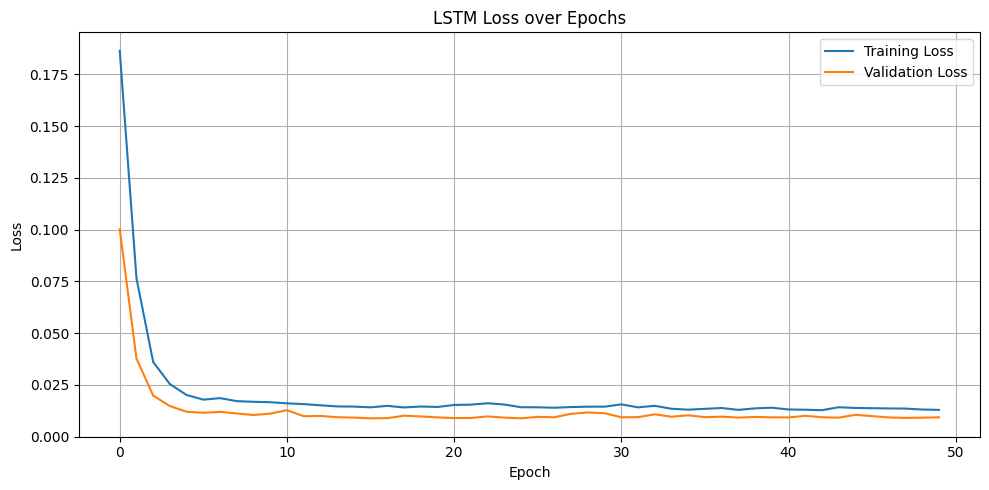

In [282]:
# Plot training and validation loss and RMSE from the model history

# Extract RMSE and loss from history
rmse = history.history['root_mean_squared_error']
val_rmse = history.history['val_root_mean_squared_error']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(10, 5))

# Plot Loss
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('LSTM Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# # Plot RMSE
# plt.subplot(1, 2, 2)
# plt.plot(rmse, label='Training RMSE')
# plt.plot(val_rmse, label='Validation RMSE')
# plt.title('Root Mean Squared Error over Epochs')
# plt.xlabel('Epoch')
# plt.ylabel('RMSE')
# plt.legend()
# plt.grid(True)

plt.tight_layout()
plt.show()

#### Make Predictions and Evaluate the Model


In [283]:
# Predict on test set
y_pred_scaled = lstm_model.predict(X_test)
# Inverse transform predictions and true values
y_pred = scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_true = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

test_results= pd.DataFrame(data= {'Test Predictions': y_pred, 'Actuals': y_true})
test_results


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step


,Test Predictions,Actuals
0,1935.170410,1814.50
1,2070.257324,2144.43
2,2077.503906,2521.10
3,1797.567749,1711.50
4,1727.926514,1712.70
...,...,...
208,2443.795410,2358.48
209,2029.139526,2209.90
210,2006.387451,1866.20
211,1935.350586,2046.00


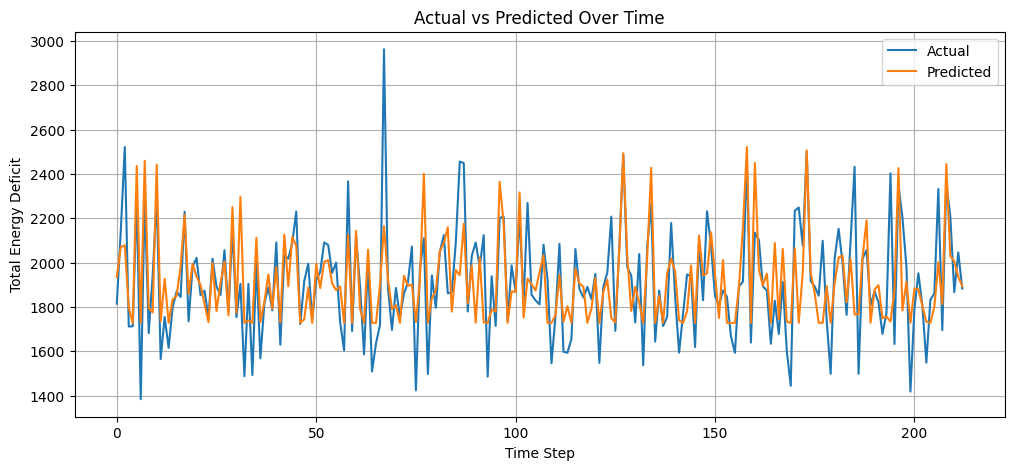

In [284]:
# Plot the Actual vs Predicted Results
plt.figure(figsize=(12, 5))
plt.plot(y_true, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title('Actual vs Predicted Over Time')
plt.xlabel('Time Step')
plt.ylabel('Total Energy Deficit')
plt.legend()
plt.grid(True)
plt.show()


In [285]:
#Evaluate the Model
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)
mape= mean_absolute_percentage_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

lstm_metrics_dict = {
    "MAE": mae,
    "MSE": mse,
    "RMSE": rmse,
    "MAPE": mape,
    "R² Score": r2
}

print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}")
print(f"R² Score: {r2:.4f}")

MAE: 128.72
MSE: 31857.73
RMSE: 178.49
MAPE: 0.07
R² Score: 0.4789


#### LSTM Hyperparamters Tuning

In [286]:
# def create_model(units1=64, units2=32, dropout_rate=0.2, learning_rate=0.001):
#     model = Sequential([
#         LSTM(units1, return_sequences=True, input_shape=input_shape),
#         LSTM(units2),
#         Dense(16, activation='relu'),
#         Dropout(dropout_rate),
#         Dense(1)
#     ])
#     optimizer = Adam(learning_rate=learning_rate, clipvalue=1.0)
#     model.compile(optimizer=optimizer, loss='mse', metrics=[RootMeanSquaredError()])
#     return model

In [287]:
# param_dist = {
#     'units1': [32, 64, 128],
#     'units2': [16, 32, 64],
#     'dropout_rate': [0.1, 0.2, 0.3],
#     'learning_rate': [0.0001, 0.0005, 0.001],
#     'batch_size': [16, 32, 64],
#     'epochs': [30, 50]
# }

In [288]:
# regressor = KerasRegressor(
#     model=create_model,
#     units1=64,  # default values, can be overridden by RandomizedSearchCV
#     units2=32,
#     dropout_rate=0.2,
#     learning_rate=0.001,
#     batch_size=32,
#     epochs=50,
#     verbose=0
# )

In [289]:

# random_search = RandomizedSearchCV(
#     estimator=regressor,
#     param_distributions=param_dist,
#     n_iter=10,  # Try 10 random combinations
#     cv=3,
#     verbose=2,
#     n_jobs=1
# )



In [290]:
# random_search.fit(X_train, y_train)

In [291]:
# print("Best params:", random_search.best_params_)
# print("Best score (negative MSE):", random_search.best_score_)


####  LSTM Hyperparameter Tuning (New)

In [292]:
def create_lstm_model(hp):
    model = Sequential()
    
    # Hyperparameters to tune
    model.add(LSTM(units=hp.Int('units', min_value=32, max_value=128, step=32),
                  return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    
    model.add(LSTM(units=hp.Int('units', min_value=32, max_value=128, step=32),
                   activation= hp.Choice('activation', values=['relu', 'tanh', 'sigmoid'])))
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)))
    model.add(Dense(1, activation='linear'))  # <-- Add this line for regression output
    # Learning rate tuning
    model.compile(optimizer=Adam(learning_rate=hp.Float('learning_rate', min_value=1e-5, max_value=1e-3, sampling='LOG')),
                  loss='mse', metrics=['mae'])
    
    return model


In [293]:
tuning_base_path = r'C:\Users\pc\Documents\Power System Planning\tuning_params'
if not os.path.exists(tuning_base_path):
    os.makedirs(tuning_base_path)


In [294]:
# Hyperparameter tuning for GRU
tuner_lstm = kt.Hyperband(
    create_lstm_model,
    objective='val_loss',  # Optimize validation loss
    max_epochs=10,
    factor=3,
    directory=os.path.join(tuning_base_path, 'lstm_tuning'),
    project_name='lstm_hyperparameter_tuning'
)
batch_size=kt.HyperParameters().Choice('batch_size', [16, 32, 64])

# Perform the hyperparameter search for GRU
tuner_lstm.search(X_train, y_train, epochs=50, validation_split= 0.1, 
                  batch_size=kt.HyperParameters().Choice('batch_size', [16, 32, 64]))

# Get the best hyperparameters
best_lstm_hp = tuner_lstm.get_best_hyperparameters(num_trials=1)[0]
print("Best LSTM Hyperparameters:", best_lstm_hp.values)

Reloading Tuner from C:\Users\pc\Documents\Power System Planning\tuning_params\lstm_tuning\lstm_hyperparameter_tuning\tuner0.json
Best LSTM Hyperparameters: {'units': 96, 'activation': 'tanh', 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.00014031767388896486, 'tuner/epochs': 10, 'tuner/initial_epoch': 4, 'tuner/bracket': 1, 'tuner/round': 1, 'tuner/trial_id': '0020'}


In [295]:
# Build the best GRU model
best_lstm_model = tuner_lstm.hypermodel.build(best_lstm_hp)
best_lstm_model.summary()

c:\Users\pc\Documents\Power System Planning\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_22 (LSTM)                  │ (None, 3, 96)          │        43,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_23 (LSTM)                  │ (None, 96)             │        74,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 16)             │         1,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 118,689 (463.63 KB)

 Trainable params: 118,689 (463.63 KB)

 Non-trainable params: 0 (0.00 B)

In [296]:
# Fit the best GRU model
history_lstm = best_lstm_model.fit(X_train, y_train, epochs=50, validation_split= 0.1, batch_size=32)

Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 0.1204 - mae: 0.3072 - val_loss: 0.0650 - val_mae: 0.2175
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0581 - mae: 0.1951 - val_loss: 0.0243 - val_mae: 0.1230
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0439 - mae: 0.1592 - val_loss: 0.0200 - val_mae: 0.1116
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0382 - mae: 0.1519 - val_loss: 0.0206 - val_mae: 0.1133
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0375 - mae: 0.1507 - val_loss: 0.0178 - val_mae: 0.1057
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0370 - mae: 0.1498 - val_loss: 0.0171 - val_mae: 0.1040
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0318 - mae: 0.1351 - val_loss: 0.0159 - val_mae: 0.1002
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0317 - mae: 0.1342 - val_loss: 0.0143 - val_mae: 0.0949
Epoch 9/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.027

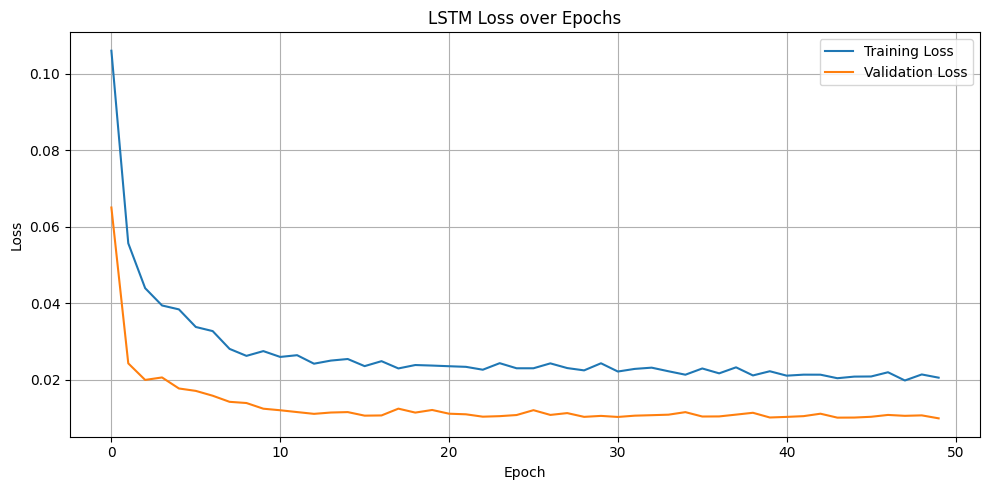

In [297]:
# Plot training and validation loss and RMSE from the model history

# Extract RMSE and loss from history
rmse = history_lstm.history['mae']
val_rmse = history_lstm.history['val_mae']
loss = history_lstm.history['loss']
val_loss = history_lstm.history['val_loss']

plt.figure(figsize=(10, 5))

# Plot Loss
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('LSTM Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# # Plot RMSE
# plt.subplot(1, 2, 2)
# plt.plot(rmse, label='Training RMSE')
# plt.plot(val_rmse, label='Validation RMSE')
# plt.title('Root Mean Squared Error over Epochs')
# plt.xlabel('Epoch')
# plt.ylabel('RMSE')
# plt.legend()
# plt.grid(True)

plt.tight_layout()
plt.show()

In [298]:
y_pred_lstm = best_lstm_model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_lstm.reshape(-1, 1)).flatten()


mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
mape= mean_absolute_percentage_error(y_true, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_true, y_pred)

lstm_best_model_dict = {
    "MAE": mae,
    "MSE": mse,
    "RMSE": rmse,
    "MAPE": mape,
    "R² Score": r2
}

print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}")
print(f"R² Score: {r2:.4f}")


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step
MAE: 138.80
MSE: 35714.74
RMSE: 188.98
MAPE: 0.07
R² Score: 0.4158


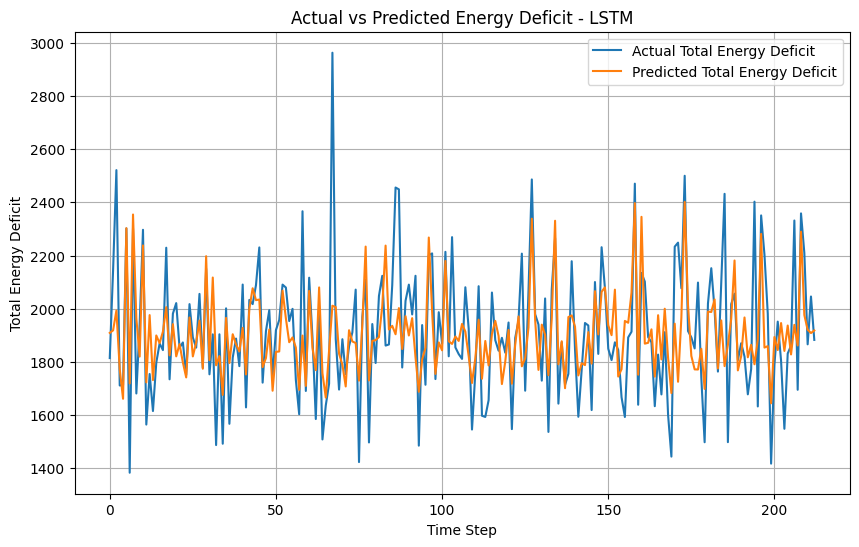

In [299]:
df_comparison_lstm = pd.DataFrame({'Actual': y_true, 'Predicted': y_pred.flatten()})

# Plot Actual vs Predicted for GRU
plt.figure(figsize=(10, 6))
plt.plot(df_comparison_lstm['Actual'].values, label='Actual Total Energy Deficit')
plt.plot(df_comparison_lstm['Predicted'].values, label='Predicted Total Energy Deficit')
plt.title('Actual vs Predicted Energy Deficit - LSTM')
plt.xlabel('Time Step')
plt.ylabel('Total Energy Deficit')
plt.legend()
plt.grid(True)
plt.show()

### XGBoost Model Training

In [300]:
X_train_flattened = X_train.reshape(X_train.shape[0], -1)
X_test_flattened = X_test.reshape(X_test.shape[0], -1)

[0]	validation_0-rmse:0.12877	validation_1-rmse:0.13735
[1]	validation_0-rmse:0.10764	validation_1-rmse:0.12600
[2]	validation_0-rmse:0.09317	validation_1-rmse:0.12012
[3]	validation_0-rmse:0.08182	validation_1-rmse:0.11798
[4]	validation_0-rmse:0.07072	validation_1-rmse:0.11743
[5]	validation_0-rmse:0.06404	validation_1-rmse:0.11676
[6]	validation_0-rmse:0.05867	validation_1-rmse:0.11562
[7]	validation_0-rmse:0.05405	validation_1-rmse:0.11508
[8]	validation_0-rmse:0.05027	validation_1-rmse:0.11498
[9]	validation_0-rmse:0.04785	validation_1-rmse:0.11510
[10]	validation_0-rmse:0.04525	validation_1-rmse:0.11456
[11]	validation_0-rmse:0.04260	validation_1-rmse:0.11464
[12]	validation_0-rmse:0.04044	validation_1-rmse:0.11457
[13]	validation_0-rmse:0.03779	validation_1-rmse:0.11384
[14]	validation_0-rmse:0.03704	validation_1-rmse:0.11386
[15]	validation_0-rmse:0.03537	validation_1-rmse:0.11386
[16]	validation_0-rmse:0.03465	validation_1-rmse:0.11396
[17]	validation_0-rmse:0.03312	validation

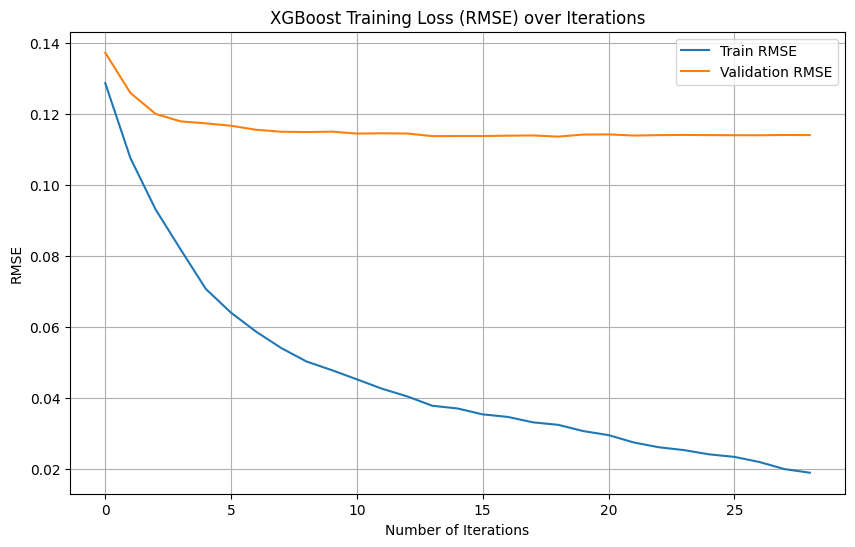

In [301]:
# Train XGBoost model with evaluation tracking and plot RMSE over iterations

from xgboost import XGBRegressor

# 1. Define the model with early stopping and RMSE evaluation metric
xgb_model = XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    eval_metric='rmse',
    early_stopping_rounds=10,
    n_estimators= 300
)

# 2. Fit the model and let XGBoost track evaluation metrics internally
xgb_model.fit(
    X_train_flattened, y_train,
    eval_set=[(X_train_flattened, y_train), (X_test_flattened, y_test)],
    verbose=True
)

# 3. Retrieve evaluation results from the trained model
evals_result = xgb_model.evals_result()

# 4. Plot RMSE for training and validation sets over boosting rounds
plt.figure(figsize=(10, 6))
plt.plot(evals_result['validation_0']['rmse'], label='Train RMSE')
plt.plot(evals_result['validation_1']['rmse'], label='Validation RMSE')
plt.title('XGBoost Training Loss (RMSE) over Iterations')
plt.xlabel('Number of Iterations')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True)
plt.show()

In [302]:
y_pred_scaled = xgb_model.predict(X_test_flattened)
# Inverse transform predictions and true values
y_pred = scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_true = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

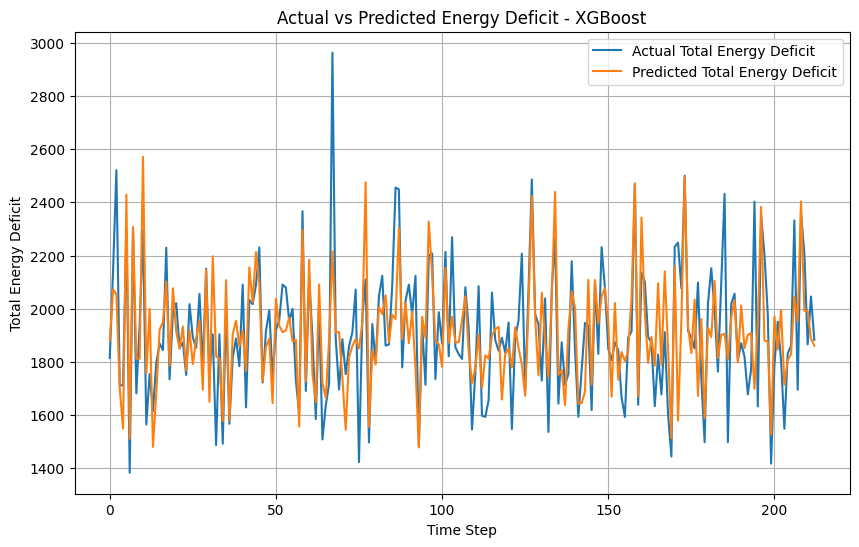

In [303]:
df_comparison = pd.DataFrame({'Actual': y_true, 'Predicted': y_pred})

# 8. Plotting Actual vs Predicted
plt.figure(figsize=(10, 6))
plt.plot(df_comparison['Actual'].values, label='Actual Total Energy Deficit')
plt.plot(df_comparison['Predicted'].values, label='Predicted Total Energy Deficit')
plt.title('Actual vs Predicted Energy Deficit - XGBoost')
plt.xlabel('Time Step')
plt.ylabel('Total Energy Deficit')
plt.legend()
plt.grid(True)
plt.show()

In [304]:
df_comparison

,Actual,Predicted
0,1814.50,1880.808594
1,2144.43,2072.714355
2,2521.10,2054.138916
3,1711.50,1702.549316
4,1712.70,1549.455200
...,...,...
208,2358.48,2403.568115
209,2209.90,1992.109131
210,1866.20,1990.701538
211,2046.00,1887.771851


In [305]:
y_pred = xgb_model.predict(X_test_flattened)

# 6. Evaluate Model using error metrics
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
mape= mean_absolute_percentage_error(y_true, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_true, y_pred)

xgb_metrics_dict = {
    "MAE": mae,
    "MSE": mse,
    "RMSE": rmse,
    "MAPE": mape,
    "R² Score": r2
}

print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}")
print(f"R² Score: {r2:.4f}")


MAE: 1910.72
MSE: 3711956.78
RMSE: 1926.64
MAPE: 1.00
R² Score: -59.7136


#### Xgboost Hyperparamter tuning

In [306]:
xgb_model_tune = XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    eval_metric='rmse',
    n_estimators=300
)

In [307]:
param_dist = {
    'n_estimators': [100, 200, 300, 400],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5, 6],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

random_search = RandomizedSearchCV(
    xgb_model_tune,
    param_distributions=param_dist,
    n_iter=10,
    cv=3,
    scoring='neg_mean_squared_error', # Maximizing RMSE (neg_mean_squared_error)
    verbose=1,
    n_jobs=-1
)


In [308]:
random_search.fit(X_train_flattened, y_train)

# Best hyperparameters
print("Best hyperparameters:", random_search.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best hyperparameters: {'subsample': 0.8, 'n_estimators': 400, 'max_depth': 4, 'learning_rate': 0.01, 'colsample_bytree': 1.0}


In [309]:
# 6. Use the best estimator to predict
best_model = random_search.best_estimator_
y_pred_best = best_model.predict(X_test_flattened)
y_pred = scaler.inverse_transform(y_pred_best.reshape(-1, 1)).flatten()

y_pred_best[0], y_pred[0]

(np.float32(0.34139088), np.float32(1922.5562))

In [310]:
mae = mean_absolute_error(y_true, y_pred_best)
mse = mean_squared_error(y_true, y_pred_best)
mape= mean_absolute_percentage_error(y_true, y_pred_best)
rmse = np.sqrt(mse)
r2 = r2_score(y_true, y_pred_best)

xgb_best_metrics_dict = {
    "MAE": mae,
    "MSE": mse,
    "RMSE": rmse,
    "MAPE": mape,
    "R² Score": r2
}

print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}")
print(f"R² Score: {r2:.4f}")

MAE: 1910.72
MSE: 3711966.94
RMSE: 1926.65
MAPE: 1.00
R² Score: -59.7137


### 1-D CNN Model Training

In [311]:
def create_cnn_model(input_shape, filters=64, kernel_size=3, dropout_rate=0.2, learning_rate=0.001):
    model = Sequential([
        Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', input_shape=input_shape),
        Flatten(),
        Dense(32, activation='relu'),
        Dropout(dropout_rate),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse', metrics=['mae'])
    return model

In [312]:
# time_steps = 3 # Use 3 previous time steps beacuse of cnn input sequence shape that accept only 3 due to its colour channel
# mask = ~np.isnan(X_scaled).any(axis=1) #Remove nan value
# X_scaled_clean = X_scaled[mask]
# X_seq, y_seq = create_sequences(X_scaled_clean, y_scaled, time_steps)

# print("X_seq shape:", X_seq.shape)  # (samples, time_steps, features)
# print("y_seq shape:", y_seq.shape)

In [313]:
#X_train_cnn, X_test_cnn, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)

In [314]:
cnn_model = create_cnn_model((X_train.shape[1], X_train.shape[2]))  # Input shape for CNN
history = cnn_model.fit(X_train, y_train, epochs=50, validation_split=0.1, batch_size=32, verbose=1)


Epoch 1/50


c:\Users\pc\Documents\Power System Planning\.venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0677 - mae: 0.2033 - val_loss: 0.0140 - val_mae: 0.0938
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0275 - mae: 0.1296 - val_loss: 0.0131 - val_mae: 0.0893
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0244 - mae: 0.1214 - val_loss: 0.0111 - val_mae: 0.0847
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0219 - mae: 0.1108 - val_loss: 0.0103 - val_mae: 0.0829
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0171 - mae: 0.0990 - val_loss: 0.0099 - val_mae: 0.0792
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0204 - mae: 0.1084 - val_loss: 0.0096 - val_mae: 0.0787
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0166 - mae: 0.1002 - val_loss: 0.0101 - val_mae: 0.0775
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0160 - mae: 0.0947 - val_loss: 0.0101 - val_mae: 0.0762
Epoch 9/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0145 - mae: 0.0937 - v

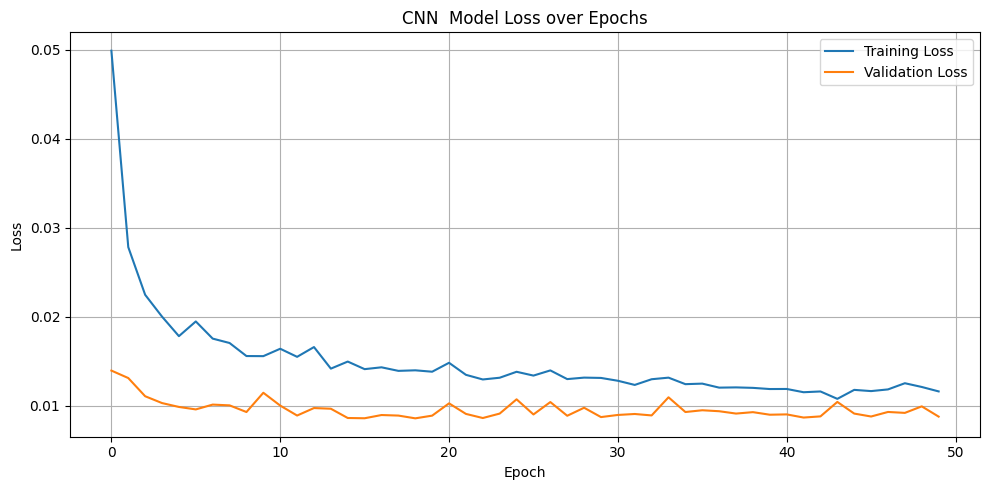

In [315]:
# Plot training and validation loss and RMSE from the model history

# Extract RMSE and loss from history
mae = history.history['mae']
val_mae = history.history['val_mae']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(10, 5))

# Plot Loss
#plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('CNN  Model Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot MAE
# plt.subplot(1, 2, 2)
# plt.plot(mae, label='Training MAE')
# plt.plot(val_mae, label='Validation MAE')
# plt.title('CNN Mean Absolute Error over Epochs')
# plt.xlabel('Epoch')
# plt.ylabel('MAE')
# plt.legend()
# plt.grid(True)

plt.tight_layout()
plt.show()

In [316]:
y_pred_cnn = cnn_model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_cnn.reshape(-1, 1)).flatten()

# Evaluate Model
# mae_cnn = mean_absolute_error(y_test, y_pred_cnn)
# mse_cnn = mean_squared_error(y_test, y_pred_cnn)
# rmse_cnn = np.sqrt(mse_cnn)
# r2_cnn = r2_score(y_test, y_pred_cnn)

mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
mape= mean_absolute_percentage_error(y_true, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_true, y_pred)

cnn_metrics_dict = {
    "MAE": mae,
    "MSE": mse,
    "RMSE": rmse,
    "MAPE": mape,
    "R² Score": r2
}

print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}")
print(f"R² Score: {r2:.4f}")


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
MAE: 127.44
MSE: 31591.67
RMSE: 177.74
MAPE: 0.07
R² Score: 0.4833


#### 1D-CNN Hyperparameter Tuning

In [317]:
def build_cnn(hp):
    model = Sequential()
    # kernel_size must be <= time_steps (which is 3)
    model.add(Conv1D(
        filters=hp.Int('filters', min_value=32, max_value=128, step=32),
        kernel_size=hp.Int('kernel_size', min_value=2, max_value=3),  # Only 2 or 3 allowed
        activation=hp.Choice('conv_activation', ['relu', 'tanh', 'sigmoid']),
        input_shape=(X_train.shape[1], X_train.shape[2])
    ))
    model.add(Flatten())
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)))
    model.add(Dense(1))
    model.compile(
        optimizer=Adam(learning_rate=hp.Float('learning_rate', min_value=1e-5, max_value=1e-3, sampling='LOG')),
        loss='mse',
        metrics=['mae']
    )
    return model

In [318]:
# Instantiate the tuner (using Hyperband for efficient tuning)
tuner = kt.Hyperband(
    build_cnn,  # The model-building function
    objective='val_loss',  # What we are optimizing
    max_epochs=10,  # Maximum number of epochs per trial
    factor=3,  # Factor for Hyperband's resources
    directory=os.path.join(tuning_base_path, 'cnn_tuning'),  # Directory to store the search results
    project_name='cnn_hyperparameter_tuning'
)

# Perform the search
tuner.search(X_train, y_train, epochs=50, validation_split= 0.1,
             batch_size=kt.HyperParameters().Choice('batch_size', [16, 32, 64]))


Reloading Tuner from C:\Users\pc\Documents\Power System Planning\tuning_params\cnn_tuning\cnn_hyperparameter_tuning\tuner0.json


In [319]:
# Get the best hyperparameters
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best Hyperparameters:", best_hp.values)



Best Hyperparameters: {'filters': 128, 'kernel_size': 2, 'conv_activation': 'relu', 'dropout_rate': 0.2, 'learning_rate': 0.0009614466105066123, 'tuner/epochs': 10, 'tuner/initial_epoch': 4, 'tuner/bracket': 2, 'tuner/round': 2, 'tuner/trial_id': '0013'}


In [320]:
# Build the model with the best hyperparameters
cnn_best_model = tuner.hypermodel.build(best_hp)
cnn_best_model.summary()



c:\Users\pc\Documents\Power System Planning\.venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)               │ (None, 2, 128)         │         3,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 32)             │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,225 (47.75 KB)

 Trainable params: 12,225 (47.75 KB)

 Non-trainable params: 0 (0.00 B)

In [321]:
# Fit the best model
history_cnn = cnn_best_model.fit(X_train, y_train, epochs=50, validation_split= 0.1, batch_size=32, verbose=1)


Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0837 - mae: 0.2184 - val_loss: 0.0152 - val_mae: 0.0984
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0255 - mae: 0.1235 - val_loss: 0.0116 - val_mae: 0.0849
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0197 - mae: 0.1083 - val_loss: 0.0098 - val_mae: 0.0777
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0184 - mae: 0.1037 - val_loss: 0.0097 - val_mae: 0.0798
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0179 - mae: 0.1003 - val_loss: 0.0108 - val_mae: 0.0778
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0158 - mae: 0.0970 - val_loss: 0.0099 - val_mae: 0.0761
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0214 - mae: 0.1103 - val_loss: 0.0104 - val_mae: 0.0760
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0182 - mae: 0.1020 - val_loss: 0.0095 - val_mae: 0.0779
Epoch 9/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0191 - mae:

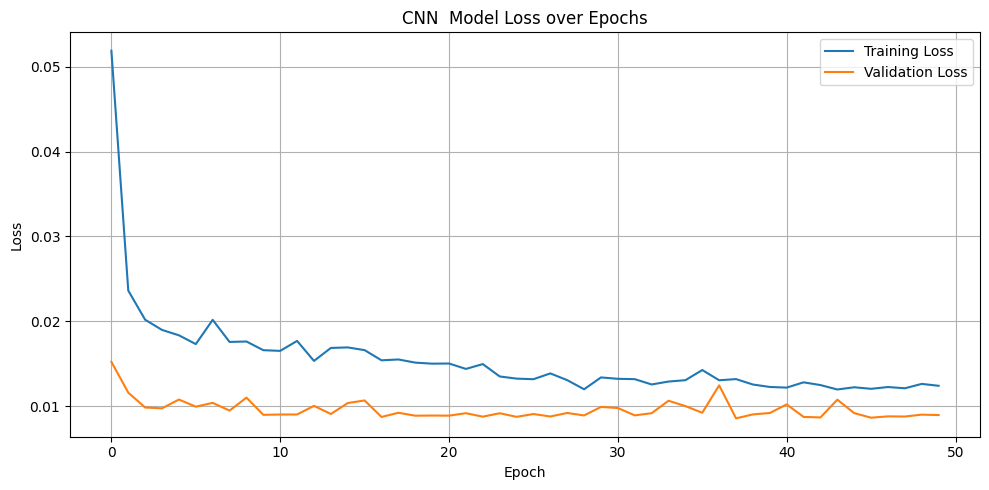

In [322]:
# Plot training and validation loss and RMSE from the model history

# Extract RMSE and loss from history
mae = history_cnn.history['mae']
val_mae = history_cnn.history['val_mae']
loss = history_cnn.history['loss']
val_loss = history_cnn.history['val_loss']

plt.figure(figsize=(10, 5))

# Plot Loss
#plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('CNN  Model Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot MAE
# plt.subplot(1, 2, 2)
# plt.plot(mae, label='Training MAE')
# plt.plot(val_mae, label='Validation MAE')
# plt.title('CNN Mean Absolute Error over Epochs')
# plt.xlabel('Epoch')
# plt.ylabel('MAE')
# plt.legend()
# plt.grid(True)

plt.tight_layout()
plt.show()

In [323]:
y_pred_cnn = cnn_best_model.predict(X_test)
y_pred_cnn = scaler.inverse_transform(y_pred_cnn.reshape(-1, 1)).flatten()


mae = mean_absolute_error(y_true, y_pred_cnn)
mse = mean_squared_error(y_true, y_pred_cnn)
mape= mean_absolute_percentage_error(y_true, y_pred_cnn)
rmse = np.sqrt(mse)
r2 = r2_score(y_true, y_pred_cnn)

cnn_best_model_dict = {
    "MAE": mae,
    "MSE": mse,
    "RMSE": rmse,
    "MAPE": mape,
    "R² Score": r2
}

print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}")
print(f"R² Score: {r2:.4f}")


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
MAE: 126.91
MSE: 32596.74
RMSE: 180.55
MAPE: 0.06
R² Score: 0.4668


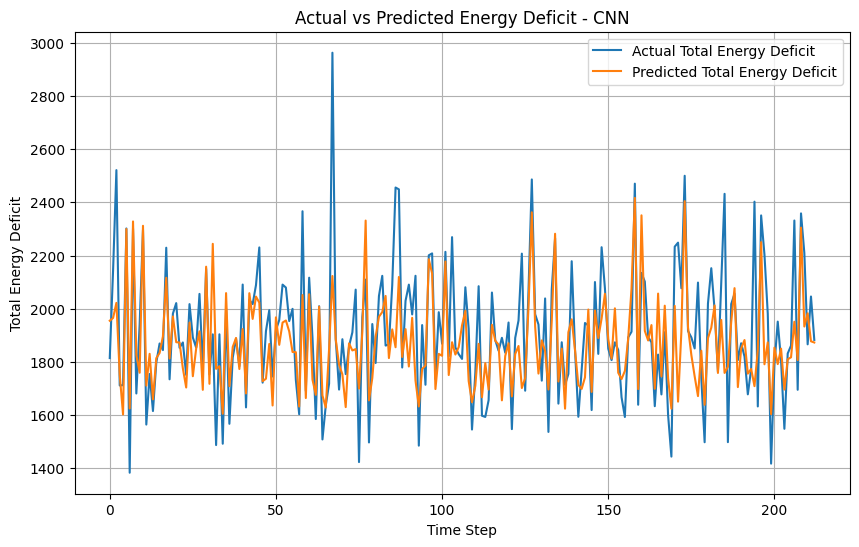

In [324]:
df_comparison_cnn = pd.DataFrame({'Actual': y_true, 'Predicted': y_pred_cnn.flatten()})

# Plotting Actual vs Predicted
plt.figure(figsize=(10, 6))
plt.plot(df_comparison_cnn['Actual'].values, label='Actual Total Energy Deficit')
plt.plot(df_comparison_cnn['Predicted'].values, label='Predicted Total Energy Deficit')
plt.title('Actual vs Predicted Energy Deficit - CNN')
plt.xlabel('Time Step')
plt.ylabel('Total Energy Deficit')
plt.legend()
plt.grid(True)
plt.show()

### GRU Model Training

In [325]:
#Build the GRU model
def build_gru_model(input_shape):
    model = Sequential()
    model.add(GRU(128, return_sequences=True, input_shape=input_shape))
    model.add((GRU(32)))
    model.add(Dense(16, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='linear'))  # Output layer for regression
    model.compile(loss= MeanSquaredError(), optimizer=Adam(learning_rate= 0.005, clipvalue= 1.0),
                  metrics= [RootMeanSquaredError()])
    return model

In [326]:
# Model training and evaluation
gru_model = build_gru_model((X_train.shape[1], X_train.shape[2]))  # Define input shape
gru_model.summary()

c:\Users\pc\Documents\Power System Planning\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_4 (GRU)                     │ (None, 3, 128)         │        55,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_5 (GRU)                     │ (None, 32)             │        15,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 71,777 (280.38 KB)

 Trainable params: 71,777 (280.38 KB)

 Non-trainable params: 0 (0.00 B)

In [327]:
history_gru = gru_model.fit(X_train, y_train, epochs=50, validation_split=0.1, batch_size=32, verbose=1)

Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 0.2243 - root_mean_squared_error: 0.2207 - val_loss: 0.1134 - val_root_mean_squared_error: 0.1302
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1058 - root_mean_squared_error: 0.1606 - val_loss: 0.0537 - val_root_mean_squared_error: 0.1056
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0564 - root_mean_squared_error: 0.1440 - val_loss: 0.0374 - val_root_mean_squared_error: 0.1314
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0371 - root_mean_squared_error: 0.1412 - val_loss: 0.0207 - val_root_mean_squared_error: 0.1021
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0263 - root_mean_squared_error: 0.1308 - val_loss: 0.0156 - val_root_mean_squared_error: 0.0953
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0215 - root_mean_squared_error: 0.1256 - val_loss: 0.0127 - val_root_mean_squared_error: 0.0943
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss:

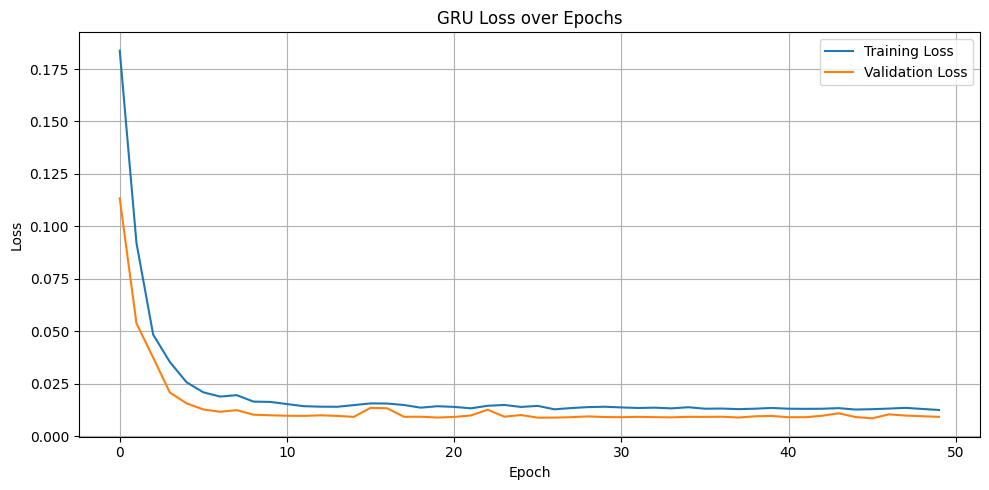

In [328]:
# Plot training and validation loss and RMSE from the model history

# Extract RMSE and loss from history
rmse = history_gru.history['root_mean_squared_error']
val_rmse = history_gru.history['val_root_mean_squared_error']
loss = history_gru.history['loss']
val_loss = history_gru.history['val_loss']

plt.figure(figsize=(10, 5))

# Plot Loss
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('GRU Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# # Plot RMSE
# plt.subplot(1, 2, 2)
# plt.plot(rmse, label='Training RMSE')
# plt.plot(val_rmse, label='Validation RMSE')
# plt.title('Root Mean Squared Error over Epochs')
# plt.xlabel('Epoch')
# plt.ylabel('RMSE')
# plt.legend()
# plt.grid(True)

plt.tight_layout()
plt.show()

In [329]:
y_pred_gru = gru_model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_gru.reshape(-1, 1)).flatten()

# Evaluate Model

mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
mape= mean_absolute_percentage_error(y_true, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_true, y_pred)

gru_metrics_dict = {
    "MAE": mae,
    "MSE": mse,
    "RMSE": rmse,
    "MAPE": mape,
    "R² Score": r2
}

print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}")
print(f"R² Score: {r2:.4f}")


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step
MAE: 126.22
MSE: 31281.66
RMSE: 176.87
MAPE: 0.07
R² Score: 0.4884


In [330]:
lstm_metrics_dict

{'MAE': 128.71665586946156,
 'MSE': 31857.726734583208,
 'RMSE': np.float64(178.48732933904077),
 'MAPE': 0.06722110086747053,
 'R² Score': 0.47892824733977446}

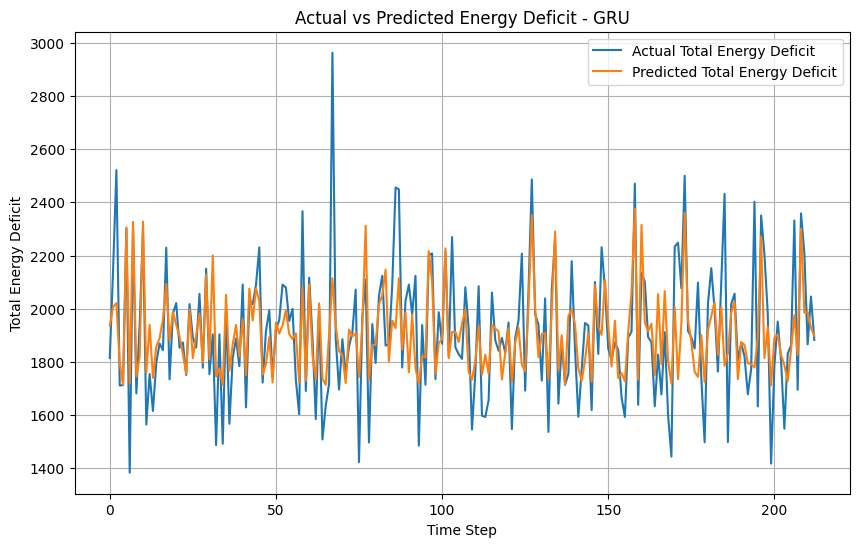

In [331]:
df_comparison_gru = pd.DataFrame({'Actual': y_true, 'Predicted': y_pred.flatten()})

# Plot Actual vs Predicted for GRU
plt.figure(figsize=(10, 6))
plt.plot(df_comparison_gru['Actual'].values, label='Actual Total Energy Deficit')
plt.plot(df_comparison_gru['Predicted'].values, label='Predicted Total Energy Deficit')
plt.title('Actual vs Predicted Energy Deficit - GRU')
plt.xlabel('Time Step')
plt.ylabel('Total Energy Deficit')
plt.legend()
plt.grid(True)
plt.show()

#### GRU Hyperparamters Tuning

In [332]:
def create_gru_model(hp):
    model = Sequential()
    
    # Hyperparameters to tune
    model.add(GRU(units=hp.Int('units', min_value=32, max_value=128, step=32),
                  return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    
    model.add(GRU(
        units=hp.Int('units', min_value=32, max_value=128, step=32),
        activation= hp.Choice('activation', values=['relu', 'tanh', 'sigmoid'])))
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)))
    model.add(Dense(1, activation='linear'))  # <-- Add this line for regression output
    # Learning rate tuning
    model.compile(optimizer=Adam(learning_rate=hp.Float('learning_rate', min_value=1e-5, max_value=1e-3, sampling='LOG')),
                  loss='mse', metrics=['mae'])
    
    return model


In [333]:
# Hyperparameter tuning for GRU
tuner_gru = kt.Hyperband(
    create_gru_model,
    objective='val_loss',  # Optimize validation loss
    max_epochs=10,
    factor=3,
    directory=os.path.join(tuning_base_path,'gru_tuning'),
    project_name='gru_hyperparameter_tuning'
)

# Perform the hyperparameter search for GRU
tuner_gru.search(X_train, y_train, epochs=50, 
                 validation_split= 0.1, 
                 batch_size=kt.HyperParameters().Choice('batch_size', [16, 32, 64]))

# Get the best hyperparameters
best_gru_hp = tuner_gru.get_best_hyperparameters(num_trials=1)[0]
print("Best GRU Hyperparameters:", best_gru_hp.values)

Reloading Tuner from C:\Users\pc\Documents\Power System Planning\tuning_params\gru_tuning\gru_hyperparameter_tuning\tuner0.json
Best GRU Hyperparameters: {'units': 96, 'activation': 'relu', 'dropout_rate': 0.2, 'learning_rate': 0.0002686310195591033, 'tuner/epochs': 10, 'tuner/initial_epoch': 4, 'tuner/bracket': 2, 'tuner/round': 2, 'tuner/trial_id': '0012'}


In [334]:
# Build the best GRU model
best_gru_model = tuner_gru.hypermodel.build(best_gru_hp)
best_gru_model.summary()

c:\Users\pc\Documents\Power System Planning\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_6 (GRU)                     │ (None, 3, 96)          │        32,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_7 (GRU)                     │ (None, 96)             │        55,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 16)             │         1,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 89,985 (351.50 KB)

 Trainable params: 89,985 (351.50 KB)

 Non-trainable params: 0 (0.00 B)

In [335]:
# Fit the best GRU model
history_gru = best_gru_model.fit(X_train, y_train, epochs=50, validation_split= 0.1, batch_size=32)

Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - loss: 0.0668 - mae: 0.2106 - val_loss: 0.0175 - val_mae: 0.1091
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0298 - mae: 0.1369 - val_loss: 0.0166 - val_mae: 0.1004
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0271 - mae: 0.1284 - val_loss: 0.0131 - val_mae: 0.0928
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0226 - mae: 0.1184 - val_loss: 0.0117 - val_mae: 0.0868
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0232 - mae: 0.1190 - val_loss: 0.0112 - val_mae: 0.0823
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0201 - mae: 0.1100 - val_loss: 0.0104 - val_mae: 0.0789
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0201 - mae: 0.1075 - val_loss: 0.0105 - val_mae: 0.0786
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0189 - mae: 0.1036 - val_loss: 0.0093 - val_mae: 0.0759
Epoch 9/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.020

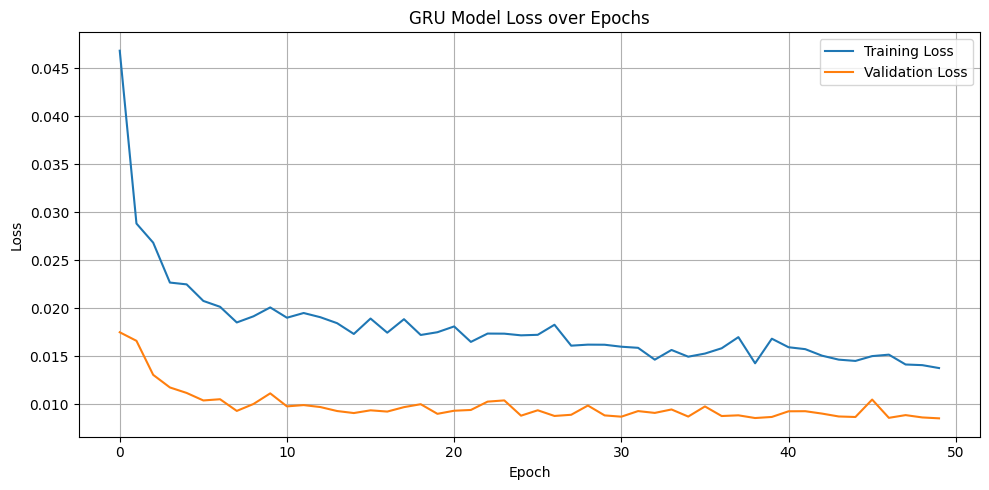

In [361]:
# Plot training and validation loss and RMSE from the model history

# Extract RMSE and loss from history
mae = history_gru.history['mae']
val_mae = history_gru.history['val_mae']
loss = history_gru.history['loss']
val_loss = history_gru.history['val_loss']

plt.figure(figsize=(10, 5))

# Plot Loss
#plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('GRU Model Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot MAE
# plt.subplot(1, 2, 2)
# plt.plot(mae, label='Training MAE')
# plt.plot(val_mae, label='Validation MAE')
# plt.title('CNN Mean Absolute Error over Epochs')
# plt.xlabel('Epoch')
# plt.ylabel('MAE')
# plt.legend()
# plt.grid(True)

plt.tight_layout()
plt.show()

In [337]:
y_pred_gru = best_gru_model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_gru.reshape(-1, 1)).flatten()

mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
mape= mean_absolute_percentage_error(y_true, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_true, y_pred)

gru_best_model_dict = {
    "MAE": mae,
    "MSE": mse,
    "RMSE": rmse,
    "MAPE": mape,
    "R² Score": r2
}

print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}")
print(f"R² Score: {r2:.4f}")


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step
MAE: 125.57
MSE: 29411.20
RMSE: 171.50
MAPE: 0.07
R² Score: 0.5189


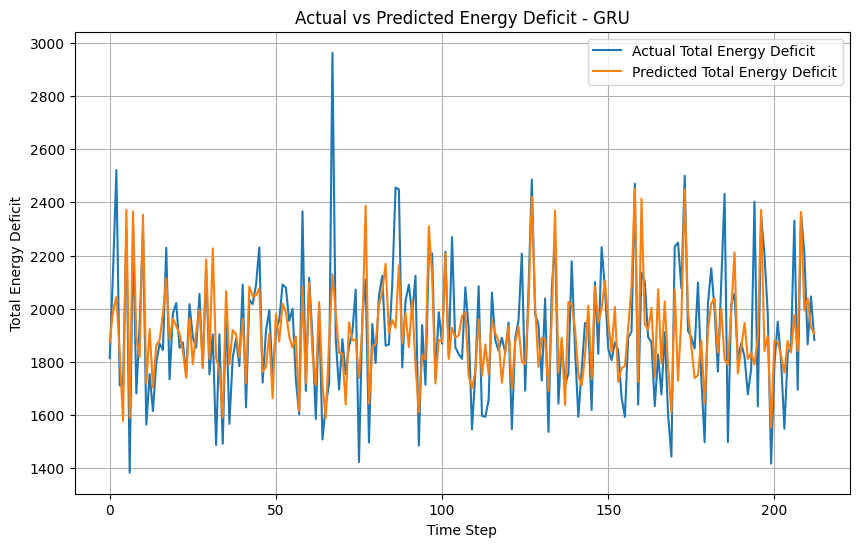

In [338]:
df_comparison_gru = pd.DataFrame({'Actual': y_true, 'Predicted': y_pred.flatten()})

# Plot Actual vs Predicted for GRU
plt.figure(figsize=(10, 6))
plt.plot(df_comparison_gru['Actual'].values, label='Actual Total Energy Deficit')
plt.plot(df_comparison_gru['Predicted'].values, label='Predicted Total Energy Deficit')
plt.title('Actual vs Predicted Energy Deficit - GRU')
plt.xlabel('Time Step')
plt.ylabel('Total Energy Deficit')
plt.legend()
plt.grid(True)
plt.show()

### BiLSTM Model Training

In [339]:
#Build the Bidirectional LSTM(model
def build_bilstm_model(input_shape):
    model = Sequential()
    model.add(Bidirectional(LSTM(128, return_sequences=True, input_shape=input_shape)))
    model.add((Bidirectional(LSTM(32))))
    model.add(Dense(16, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='linear'))  # Output layer for regression
    model.compile(loss= MeanSquaredError(), optimizer=Adam(learning_rate= 0.005, clipvalue= 1.0),
                  metrics= [RootMeanSquaredError()])
    return model

In [340]:
# Model training and evaluation
bilstm_model = build_bilstm_model((X_train.shape[1], X_train.shape[2]))  # Define input shape
bilstm_model.summary()

c:\Users\pc\Documents\Power System Planning\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_8 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_9 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [341]:
history_bilstm = bilstm_model.fit(X_train, y_train, epochs=50, validation_split=0.1, batch_size=32, verbose=1)

Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 9s 92ms/step - loss: 0.2543 - root_mean_squared_error: 0.2230 - val_loss: 0.0973 - val_root_mean_squared_error: 0.1198
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0812 - root_mean_squared_error: 0.1370 - val_loss: 0.0315 - val_root_mean_squared_error: 0.0968
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0361 - root_mean_squared_error: 0.1387 - val_loss: 0.0175 - val_root_mean_squared_error: 0.1007
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0224 - root_mean_squared_error: 0.1276 - val_loss: 0.0123 - val_root_mean_squared_error: 0.0955
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0178 - root_mean_squared_error: 0.1221 - val_loss: 0.0109 - val_root_mean_squared_error: 0.0946
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0163 - root_mean_squared_error: 0.1206 - val_loss: 0.0117 - val_root_mean_squared_error: 0.1021
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss:

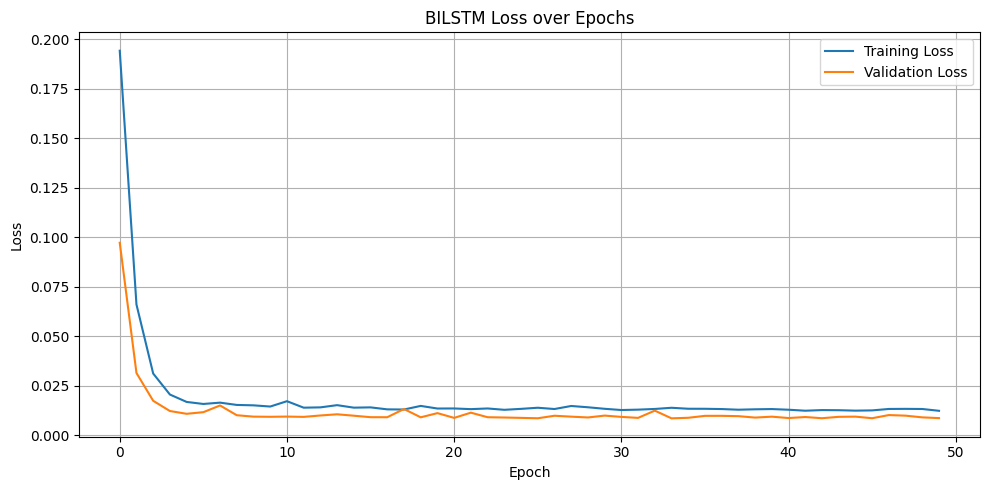

In [342]:
# Plot training and validation loss and RMSE from the model history

# Extract RMSE and loss from history
rmse = history_bilstm.history['root_mean_squared_error']
val_rmse = history_bilstm.history['val_root_mean_squared_error']
loss = history_bilstm.history['loss']
val_loss = history_bilstm.history['val_loss']

plt.figure(figsize=(10, 5))

# Plot Loss
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('BILSTM Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# # Plot RMSE
# plt.subplot(1, 2, 2)
# plt.plot(rmse, label='Training RMSE')
# plt.plot(val_rmse, label='Validation RMSE')
# plt.title('Root Mean Squared Error over Epochs')
# plt.xlabel('Epoch')
# plt.ylabel('RMSE')
# plt.legend()
# plt.grid(True)

plt.tight_layout()
plt.show()

In [343]:
y_pred_bilstm = bilstm_model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_bilstm.reshape(-1, 1)).flatten()

# Evaluate Model

mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
mape= mean_absolute_percentage_error(y_true, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_true, y_pred)

bilstm_metrics_dict = {
    "MAE": mae,
    "MSE": mse,
    "RMSE": rmse,
    "MAPE": mape,
    "R² Score": r2
}

print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}")
print(f"R² Score: {r2:.4f}")


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step
MAE: 128.78
MSE: 32106.99
RMSE: 179.18
MAPE: 0.07
R² Score: 0.4749


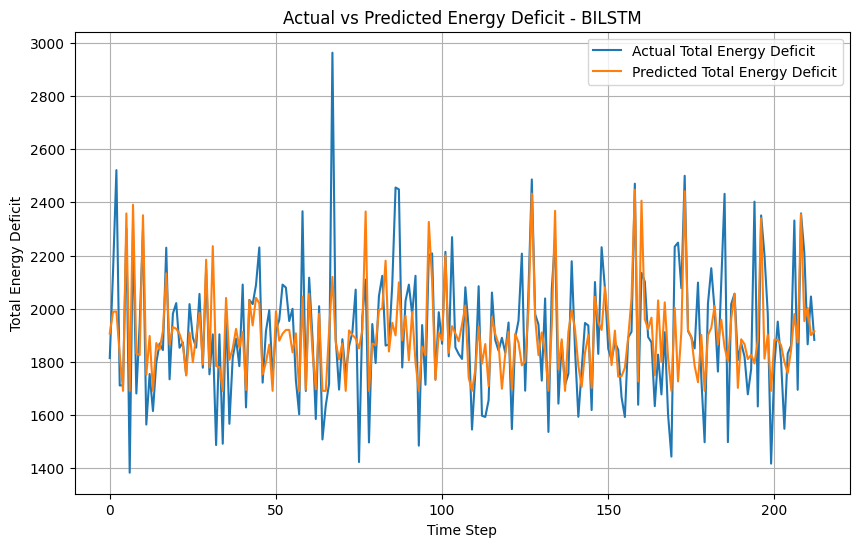

In [344]:
df_comparison_bilstm = pd.DataFrame({'Actual': y_true, 'Predicted': y_pred.flatten()})

# Plot Actual vs Predicted for GRU
plt.figure(figsize=(10, 6))
plt.plot(df_comparison_bilstm['Actual'].values, label='Actual Total Energy Deficit')
plt.plot(df_comparison_bilstm['Predicted'].values, label='Predicted Total Energy Deficit')
plt.title('Actual vs Predicted Energy Deficit - BILSTM')
plt.xlabel('Time Step')
plt.ylabel('Total Energy Deficit')
plt.legend()
plt.grid(True)
plt.show()

#### BiLSTM Hyperparamter Tuning

In [345]:
def create_bilstm_model(hp):
    model = Sequential()
    
    # Hyperparameters to tune
    model.add(Bidirectional(
        LSTM(
            units=hp.Int('units', min_value=32, max_value=128, step=32),
            activation=hp.Choice('activation', values=['relu', 'tanh', 'sigmoid']),
            return_sequences=True
        ),
        input_shape=(X_train.shape[1], X_train.shape[2])
    ))
    
    model.add(Bidirectional(
        LSTM(
            units=hp.Int('units', min_value=32, max_value=128, step=32),
            activation=hp.Choice('activation', values=['relu', 'tanh', 'sigmoid'])
        )
    ))
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)))
    model.add(Dense(1, activation='linear'))  # <-- Add this line for regression output
    # Learning rate tuning
    model.compile(optimizer=Adam(learning_rate=hp.Float('learning_rate', min_value=1e-5, max_value=1e-3, sampling='LOG')),
                  loss='mse', metrics=['mae'])
    
    return model

In [346]:
# Hyperparameter tuning for BiLSTM
tuner_bilstm = kt.Hyperband(
    create_bilstm_model,
    objective='val_loss',  # Optimize validation loss
    max_epochs=10,
    factor=3,
    directory= os.path.join(tuning_base_path, 'bilstm_tuning'),
    project_name='bilstm_hyperparameter_tuning'
)

# Perform the hyperparameter search for BiLSTM
tuner_bilstm.search(X_train, y_train, epochs=50, validation_split=0.1, 
                    batch_size=kt.HyperParameters().Choice('batch_size', [16, 32, 64]))

# Get the best hyperparameters
best_bilstm_hp = tuner_bilstm.get_best_hyperparameters(num_trials=1)[0]
print("Best BiLSTM Hyperparameters:", best_bilstm_hp.values)



Reloading Tuner from C:\Users\pc\Documents\Power System Planning\tuning_params\bilstm_tuning\bilstm_hyperparameter_tuning\tuner0.json
Best BiLSTM Hyperparameters: {'units': 64, 'activation': 'tanh', 'dropout_rate': 0.2, 'learning_rate': 0.00020926623313509532, 'tuner/epochs': 10, 'tuner/initial_epoch': 4, 'tuner/bracket': 2, 'tuner/round': 2, 'tuner/trial_id': '0012'}


In [347]:
# Build the best BiLSTM model
best_bilstm_model = tuner_bilstm.hypermodel.build(best_bilstm_hp)
best_bilstm_model.summary()


c:\Users\pc\Documents\Power System Planning\.venv\lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_10                │ (None, 3, 128)         │        40,960 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_11                │ (None, 128)            │        98,816 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 16)             │         2,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 141,857 (554.13 KB)

 Trainable params: 141,857 (554.13 KB)

 Non-trainable params: 0 (0.00 B)

In [348]:
# Fit the best BiLSTM model
history_bilstm = best_bilstm_model.fit(X_train, y_train, epochs=50, validation_split= 0.1, batch_size=32)


Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - loss: 0.0729 - mae: 0.2196 - val_loss: 0.0180 - val_mae: 0.1068
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0257 - mae: 0.1290 - val_loss: 0.0155 - val_mae: 0.0981
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0250 - mae: 0.1241 - val_loss: 0.0140 - val_mae: 0.0933
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0209 - mae: 0.1157 - val_loss: 0.0121 - val_mae: 0.0864
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0186 - mae: 0.1061 - val_loss: 0.0101 - val_mae: 0.0797
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0182 - mae: 0.1040 - val_loss: 0.0101 - val_mae: 0.0768
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0189 - mae: 0.1074 - val_loss: 0.0100 - val_mae: 0.0756
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0187 - mae: 0.1048 - val_loss: 0.0092 - val_mae: 0.0741
Epoch 9/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.016

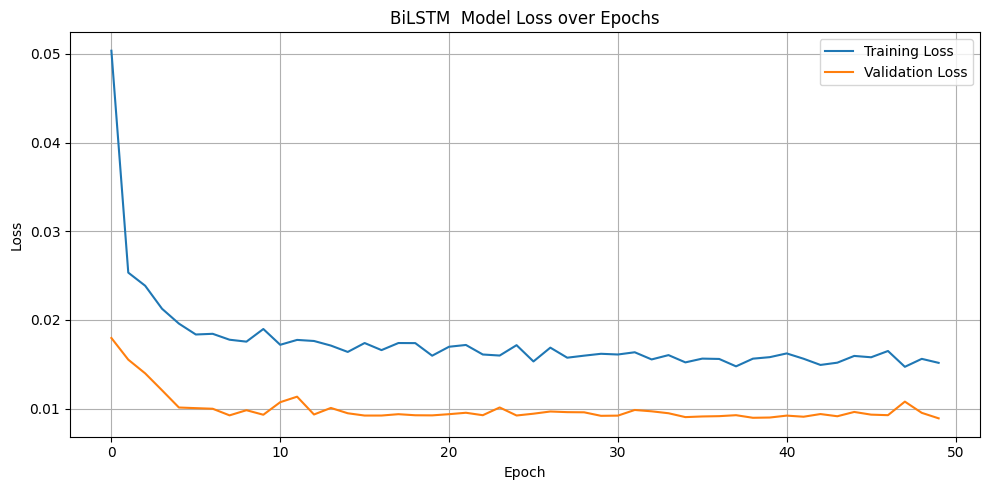

In [349]:
# Plot training and validation loss and RMSE from the model history

# Extract RMSE and loss from history
mae = history_bilstm.history['mae']
val_mae = history_bilstm.history['val_mae']
loss = history_bilstm.history['loss']
val_loss = history_bilstm.history['val_loss']

plt.figure(figsize=(10, 5))

# Plot Loss
#plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('BiLSTM  Model Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot MAE
# plt.subplot(1, 2, 2)
# plt.plot(mae, label='Training MAE')
# plt.plot(val_mae, label='Validation MAE')
# plt.title('CNN Mean Absolute Error over Epochs')
# plt.xlabel('Epoch')
# plt.ylabel('MAE')
# plt.legend()
# plt.grid(True)

plt.tight_layout()
plt.show()

In [350]:
y_pred_bilstm = best_bilstm_model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_bilstm.reshape(-1, 1)).flatten()


mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
mape= mean_absolute_percentage_error(y_true, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_true, y_pred)

bilstm_best_model_dict = {
    "MAE": mae,
    "MSE": mse,
    "RMSE": rmse,
    "MAPE": mape,
    "R² Score": r2
}

print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}")
print(f"R² Score: {r2:.4f}")


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step
MAE: 128.28
MSE: 31510.99
RMSE: 177.51
MAPE: 0.07
R² Score: 0.4846


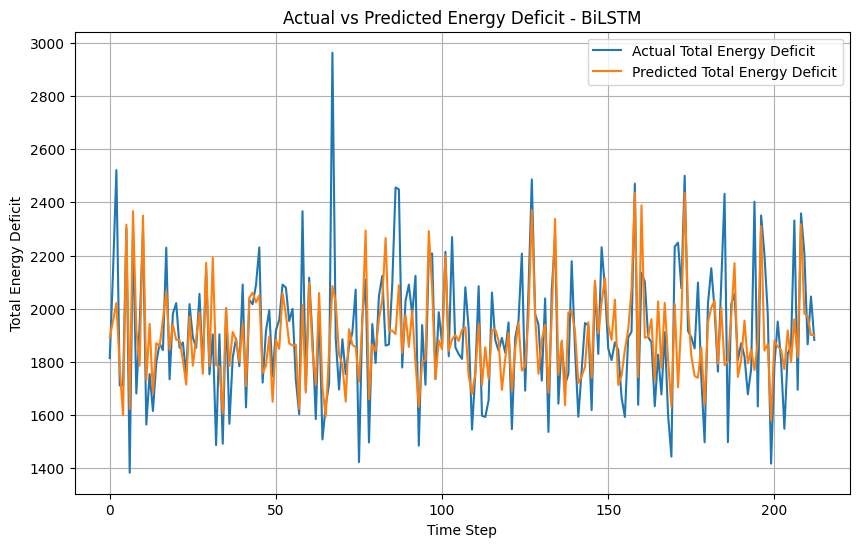

In [351]:
df_comparison_bilstm = pd.DataFrame({'Actual': y_true, 'Predicted': y_pred.flatten()})

# Plot Actual vs Predicted for GRU
plt.figure(figsize=(10, 6))
plt.plot(df_comparison_bilstm['Actual'].values, label='Actual Total Energy Deficit')
plt.plot(df_comparison_bilstm['Predicted'].values, label='Predicted Total Energy Deficit')
plt.title('Actual vs Predicted Energy Deficit - BiLSTM')
plt.xlabel('Time Step')
plt.ylabel('Total Energy Deficit')
plt.legend()
plt.grid(True)
plt.show()

### Model Comparison

In [352]:
#Create a dataframe to compare all models' metrics
model_metrics= {
    "LSTM": lstm_metrics_dict,
    #"XGBoost": xgb_metrics_dict,
    "CNN": cnn_metrics_dict,
    "GRU": gru_metrics_dict,
    "BiLSTM": bilstm_metrics_dict
}

metrics_df= pd.DataFrame(model_metrics).T
metrics_df


,MAE,MSE,RMSE,MAPE,R² Score
LSTM,128.716656,31857.726735,178.487329,0.067221,0.478928
CNN,127.439388,31591.674627,177.740470,0.065817,0.483280
GRU,126.218082,31281.657287,176.866213,0.066191,0.488351
BiLSTM,128.782932,32106.990813,179.184237,0.067298,0.474851


In [353]:
#Create a dataframe to compare all models' metrics
best_model_metrics= {
    "LSTM": lstm_best_model_dict,
    #"XGBoost": xgb_metrics_dict,
    "CNN": cnn_best_model_dict,
    "GRU": gru_best_model_dict,
    "BiLSTM": bilstm_best_model_dict
}

best_metrics_df= pd.DataFrame(best_model_metrics).T
best_metrics_df

,MAE,MSE,RMSE,MAPE,R² Score
LSTM,138.800570,35714.739733,188.983438,0.072510,0.415842
CNN,126.906790,32596.738973,180.545670,0.064824,0.466841
GRU,125.568953,29411.195567,171.496926,0.065465,0.518944
BiLSTM,128.281497,31510.991507,177.513356,0.066476,0.484600


In [354]:
metrics_base_path = r'C:\Users\pc\Documents\Power System Planning\model_metrics'
if not os.path.exists(metrics_base_path):
    os.makedirs(metrics_base_path)

metrics_df.to_csv(os.path.join(metrics_base_path, 'model_metrics_comparison.csv'))
best_metrics_df.to_csv(os.path.join(metrics_base_path, 'best_model_metrics.csv'))

In [355]:
#Group the metrics by desecnding order of RMSE
metrics_df_sorted = metrics_df.sort_values(by='MSE', ascending=True)
metrics_df_sorted

,MAE,MSE,RMSE,MAPE,R² Score
GRU,126.218082,31281.657287,176.866213,0.066191,0.488351
CNN,127.439388,31591.674627,177.740470,0.065817,0.483280
LSTM,128.716656,31857.726735,178.487329,0.067221,0.478928
BiLSTM,128.782932,32106.990813,179.184237,0.067298,0.474851


In [362]:
#Group the metrics by desecnding order of RMSE
best_metrics_df_sorted = best_metrics_df.sort_values(by='MSE', ascending=True)
best_metrics_df_sorted.to_csv(os.path.join(metrics_base_path, 'best_model_metrics_sorted.csv'))

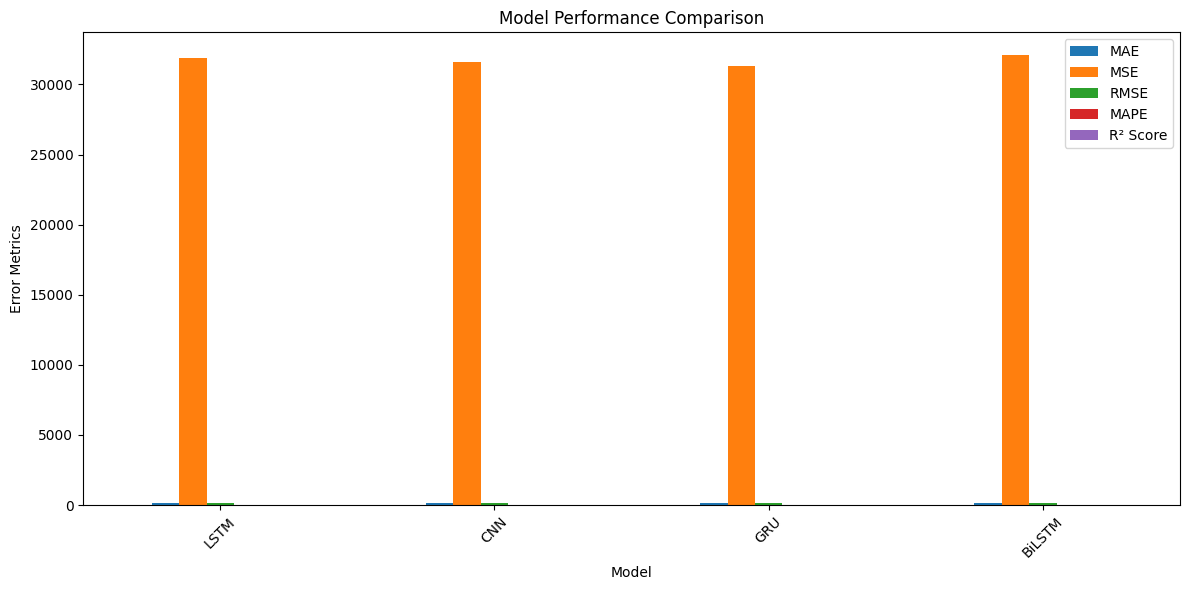

In [357]:
#Plot the metrics
metrics_df.plot(kind='bar', figsize=(12, 6))
plt.title('Model Performance Comparison')
plt.xlabel('Model')
plt.ylabel('Error Metrics')
plt.xticks(rotation=45)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()


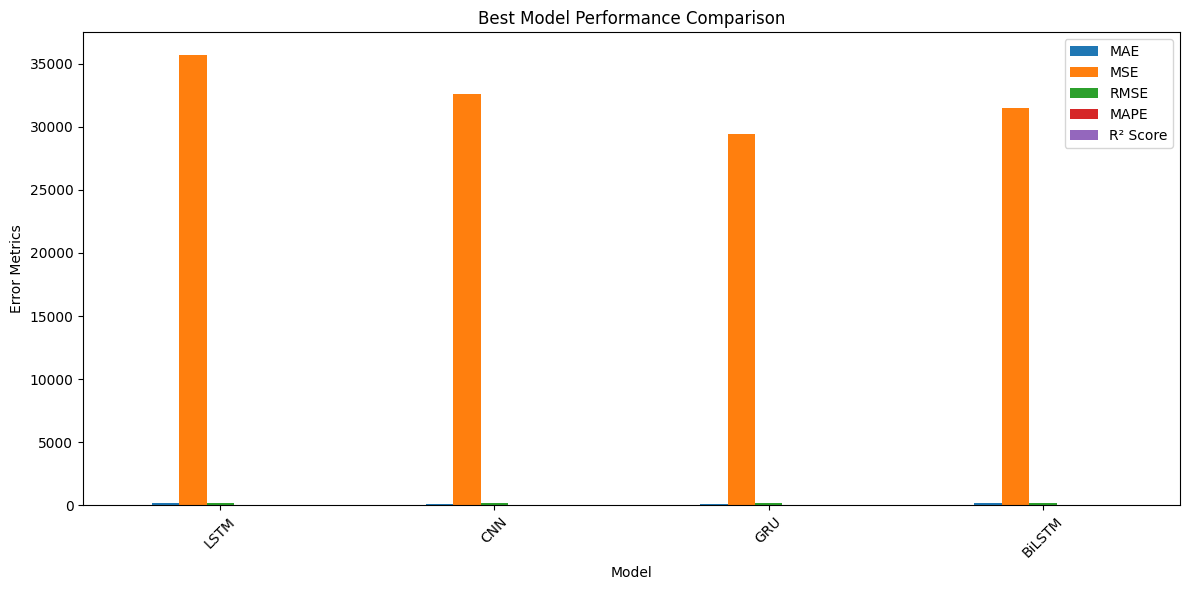

In [358]:
#Plot the best metrics
best_metrics_df.plot(kind='bar', figsize=(12, 6))
plt.title('Best Model Performance Comparison')
plt.xlabel('Model')
plt.ylabel('Error Metrics')
plt.xticks(rotation=45)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()


### Save the Best Model

In [359]:
# Save the best model
best_model_name= best_metrics_df_sorted.index[0]
if best_model_name == 'LSTM':
    best_model = best_lstm_model
elif best_model_name == 'CNN':
    best_model = cnn_best_model
elif best_model_name == 'GRU':
    best_model = best_gru_model
elif best_model_name == 'BiLSTM':
    best_model = best_bilstm_model
else:
    raise ValueError("Unknown best model name")

In [360]:
# Save and dump best model using a valid Keras extension
best_model_path = os.path.join(metrics_base_path, f'{best_model_name}_model.keras')
best_model.save(best_model_path)